In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import pipeline_plan_functions.utils.pipe_db_handler as dbh
import pipeline_plan_functions.utils.data_types as dth
from python_utils.utils.logger import logger
import alloc_functions.feasibility_functions as ff
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import matplotlib
import pickle
# import plotly.graph_objects as go
mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')
FPS_COLOURS = ['#004A9C', '#45D281', '#FEC001', '#A365E0', '#5B9BD5',
               '#FF0000', '#0563C1', '#954F72']

In [2]:
specs = (101, 102, 115, 116, 117)
good_sites = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 17, 20, 22, 28, 13, 24]
nft_sites = (13, 24)
tru_spec_dict = {
    101: 1,
    102: 2,
    115: 3,
    116: 4,
    117: 5
}
XPOWER = 0.98
MAX_SHOREPOWER_HOURS = 5.38  # hours
NEW_SHOREPOWER_HOURS = 5.5  # hours
CHARGER_EFF = 0.9
BATTERY_USABLE = 0.8
DEFAULT_WAIT = 8  # HOURS
tru_battery_kwh = [30*BATTERY_USABLE, 24*BATTERY_USABLE, 19*BATTERY_USABLE, 14*BATTERY_USABLE]
tru_battery_dict = {'Future': 30*BATTERY_USABLE, 'Long range': 24*BATTERY_USABLE,
                    'Medium range': 19*BATTERY_USABLE, 'Short range': 14*BATTERY_USABLE}
tru_charger_kw = 9
remove_charging_time = 0.5
vehicle_specifications = ff.find_vehicle_spec(specs)
vehicle_specifications['kwh_mile'] = 0
vehicle_specifications['diesel_l_mile'] = 0
elec_vehicles = vehicle_specifications['fuel_type'] == 'electric'
diesel_vehicles = vehicle_specifications['fuel_type'] == 'diesel'
vehicle_specifications.loc[elec_vehicles, 'kwh_mile'] = vehicle_specifications.loc[elec_vehicles, 'energy_use']
vehicle_specifications.loc[diesel_vehicles, 'diesel_l_mile'] = vehicle_specifications.loc[diesel_vehicles, 'energy_use']
tru_specs = ff.find_tru_spec((1, 2, 3, 4, 5))
vehicle_specifications['tru_id'] = vehicle_specifications.index.map(tru_spec_dict)
vehicle_specifications = vehicle_specifications.reset_index()
vehicle_specifications = vehicle_specifications.merge(
    tru_specs,
    left_on='tru_id', right_on='tru_id', how='left')
vehicle_specifications = vehicle_specifications.set_index('spec_id')
good_specs = vehicle_specifications['vehicle_model'].to_dict()
site_dict = ff.get_site_name_dict(2)

sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
cnx = dbh.create_alch_engine()
vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
vehicle_ref_dict = vehicle_df['refrigerated'].to_dict()
cnx.dispose()

### Get Routes

In [26]:
cnx = dbh.create_alch_engine()
site_dict = ff.get_site_name_dict(2)
sql_query = f"SELECT * FROM t_route_master WHERE client_id = 3"
routes = pd.read_sql_query(sql_query, con=cnx)
routes['spec_id'] = routes['vehicle_id'].map(vehicle_spec_dict)
routes['refrigerated'] = routes['vehicle_id'].map(vehicle_ref_dict).astype(bool)
routes = routes[(routes['spec_id'].isin(good_specs.keys()))
                & routes['refrigerated']].copy()
routes['good_site'] = ((routes['site_id_start'].isin(good_sites))
                       & (routes['site_id_end'].isin(good_sites)))
routes.sort_values(by=['vehicle_id', 'departure_time'], inplace=True)


In [27]:
routes['same_return'] = routes['site_id_start'] == routes['site_id_end']
routes['start_right_id'] = False
routes['duration_hours'] = (routes['arrival_time'] - routes['departure_time']).dt.total_seconds()/3600
routes['date'] = routes['departure_time'].dt.date
routes['start_time'] = (routes['departure_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24
routes['end_time'] = (routes['arrival_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24
routes['last_wait_onsite'] = (routes['departure_time']
                              - routes['arrival_time'].shift(1)).dt.total_seconds()/3600
routes['next_wait_onsite'] = (routes['departure_time'].shift(-1)
                              - routes['arrival_time']).dt.total_seconds()/3600
routes['week'] = routes['departure_time'].dt.isocalendar()['week']
mask_change_veh = routes['vehicle_id'] != routes['vehicle_id'].shift(1)
routes.loc[mask_change_veh, 'last_wait_onsite'] = 0
mask_change_veh = routes['vehicle_id'] != routes['vehicle_id'].shift(-1)
routes.loc[mask_change_veh, 'next_wait_onsite'] = 0
routes.drop(columns=['payload', 'number_crates', 'client_id'], inplace=True)

spec_stats = 100*routes.groupby('spec_id')[['same_return']].mean().round(3)
spec_stats['vehicle_type'] = spec_stats.index.map(good_specs)

In [9]:
count_routes_per_day = routes.groupby(['spec_id', 'vehicle_id', 'date'])[['distance_miles']].count()
avg_per_spec = count_routes_per_day.groupby('spec_id').mean()
times_per_spec = routes.groupby('spec_id').agg({
    'duration_hours': ['median', ff.q75, ff.q95],
    'last_wait_onsite': ['median', ff.q25, ff.q05]})
times_per_spec.columns = ['median_duration_hours', '75th_duration_hours', '95th_duration_hours',
                          'median_wait_hours', '25th_wait_hours', '5th_wait_hours']
avg_per_spec = avg_per_spec.merge(times_per_spec, left_index=True, right_index=True)
avg_per_spec.rename(columns={'client_id': 'routes_per_day_per_vehicle'}, inplace=True)
avg_per_spec.to_csv('sample/tru3/spec_averages.csv')

### Cleanup routes

207830


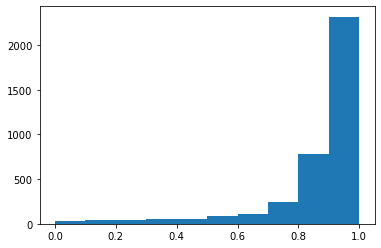

In [10]:
vehicle_good_sites = routes.groupby('vehicle_id')['good_site'].mean()
frequent_vehicles = vehicle_good_sites.loc[vehicle_good_sites > 0.6].index
plt.hist(vehicle_good_sites, cumulative=True)
print(len(routes))

In [11]:
cols = ['site_id_start', 'site_id_end', 'departure_time', 'arrival_time',
       'vehicle_id', 'distance_miles', 'route_id',
       'number_order', 'driving_time', 'duration_hours', 'date',
       'start_time', 'end_time', 'last_wait_onsite', 'next_wait_onsite',
       'week', 'good_site']
# Either started from a real depot or were in another site for short time
mask_good_start = ((routes['site_id_start'].isin(good_sites))
                   | (routes['last_wait_onsite'] < 3))
# Belong to a vehicle that operates mostly in the depots
mask_good_vehicles = routes['vehicle_id'].isin(frequent_vehicles)
mask_decent_wait = routes['next_wait_onsite'] >= 1
mask_good_end = routes['site_id_end'].isin(good_sites)
routes_cleaned = routes[mask_good_start & mask_good_vehicles
                        & mask_decent_wait & mask_good_end].copy()

In [12]:
n_routes = len(routes_cleaned)
new_n_routes = 0
while n_routes != new_n_routes:
    n_routes = len(routes_cleaned)
    end_routes = ff.edge_routes(routes_cleaned)
    routes_cleaned = routes_cleaned.merge(end_routes, how='left', left_on=['vehicle_id', 'departure_time'], right_on=['vehicle_id', 'date_edge'])
    routes_cleaned['edge_routes'] = routes_cleaned['edge_routes'].fillna(False)
    routes_cleaned = routes_cleaned[(routes_cleaned['good_site']) | (~routes_cleaned['edge_routes'])]
    new_n_routes = len(routes_cleaned)
    print(n_routes, new_n_routes)
    routes_cleaned.drop(columns=['date_edge', 'edge_routes'], inplace=True)
end_routes = ff.edge_routes(routes_cleaned)
routes_cleaned = routes_cleaned.merge(end_routes, how='left', left_on=['vehicle_id', 'departure_time'], right_on=['vehicle_id', 'date_edge'])
routes_cleaned['edge_routes'] = routes_cleaned['edge_routes'].fillna(False)
routes_cleaned.drop(columns=['date_edge'], inplace=True)

183560 183464
183464 183464


### eTRU analysis

In [14]:
season = 'summer'
route_kw = vehicle_specifications[f'route_power_{season}_kw'].to_dict()
shorepower_kw = vehicle_specifications[f'shorepower_{season}_kw'].to_dict()

mask_missing_wait = (routes_cleaned['edge_routes']) & (routes_cleaned['next_wait_onsite'] == 0)
routes_cleaned.loc[mask_missing_wait, 'next_wait_onsite'] = DEFAULT_WAIT
routes_cleaned['route_kwh'] = routes_cleaned['duration_hours'] * routes_cleaned['spec_id'].map(route_kw)
routes_cleaned['shorepower_time'] = routes_cleaned['next_wait_onsite'].clip(upper=MAX_SHOREPOWER_HOURS)
routes_cleaned['shorepower_kwh'] = routes_cleaned['shorepower_time'] * routes_cleaned['spec_id'].map(shorepower_kw)
routes_cleaned['recharge_power_kw'] = (routes_cleaned['route_kwh']/CHARGER_EFF) / (routes_cleaned['next_wait_onsite'] - remove_charging_time)
cols = ['site_id_start', 'vehicle_id', 'route_id',
       'site_id_end', 'spec_id', 'duration_hours', 'date', 'start_time',
       'end_time', 'next_wait_onsite', 'route_kwh', 'shorepower_time',
       'shorepower_kwh', 'recharge_power_kw', 'battery_choice', 'edge_routes']
routes_cleaned['battery_choice'] = 100
for battery in tru_battery_kwh:
    mask_feasible_battery = routes_cleaned['route_kwh'] <= battery
    routes_cleaned.loc[mask_feasible_battery, 'battery_choice'] = battery
routes_cleaned[cols].sort_values(by='recharge_power_kw').tail()
pickle.dump(routes_cleaned, open('sample/tru3/routes_cleaned.pkl', 'wb'))

In [15]:
route_feasibility = routes_cleaned.groupby(['spec_id', 'battery_choice'])['site_id_start'].count()
route_feasibility = route_feasibility.unstack().fillna(0)
route_feasibility.index = route_feasibility.index.map(good_specs)
total_routes = route_feasibility.sum(axis=1).values[:, None]
reverse_tru_bat_dict = {tru_battery_dict[key]: key for key in tru_battery_dict.keys()}
reverse_tru_bat_dict[100] = 'Unfeasible'
route_feasibility.columns = route_feasibility.columns.map(reverse_tru_bat_dict)
route_feasibility

battery_choice,Short range,Medium range,Long range,Future
spec_id,,,,
Rigid 4x2,34279.0,1259.0,0.0,0.0
Rigid 6x2,6671.0,1077.0,451.0,12.0
Trailer 57 13.6m,98209.0,18857.0,8682.0,1443.0
Trailer 86 13.6m,1171.0,374.0,234.0,144.0
Short Trailer,8318.0,1737.0,546.0,0.0


### Create site/group allocations

In [22]:
RUN = 211
routes_cleaned = pickle.load(open('sample/tru3/routes_cleaned.pkl', 'rb'))
connection, cur = dbh.database_connection('test')
nft_sites = (13, 24)
inputs = dh.get_inputs('t_run_allocation', RUN, connection, cur)
alloc_table = ff.create_allocation_table(inputs, nft_sites, specs, connection)
mask_good_sites = routes_cleaned['site_id_end'].isin(nft_sites)
route_summary = routes_cleaned.groupby(['site_id_end', 'spec_id']).agg({
    'vehicle_id': 'nunique',
    'route_id': 'count'
})
rename_dict = {
    'vehicle_id': 'num_v',
    'route_id': 'num_r'
}
route_summary.rename(columns=rename_dict, inplace=True)
alloc_table = alloc_table.merge(
    route_summary,
    left_on=['site_id', 'vehicle1'], right_index=True, how='inner')
alloc_table['xmpg'] = 0
alloc_table['num_v_final'] = alloc_table['num_v']
alloc_table['num_charger2'] = 0
dbh.upload_table(alloc_table, 't_allocation')
alloc_table.set_index('allocation_id', inplace=True)

2022-08-25 16:58:58|DEBUG|data_handler.py(39)|get_inputs|read inputs for run 211
2022-08-25 16:58:58|DEBUG|controller.py(50)|get_fps_allocation_id|reading last allocation ID
2022-08-25 16:58:59|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_allocation


In [24]:
# iterate over all allocation IDs
allocation_ids = alloc_table.index.values
for idx in allocation_ids:
# for idx in [757]:
    # find the routes that end on the site for that specific spec id
    mask_routes_alloc = ((routes_cleaned['site_id_end'] == alloc_table.loc[idx, 'site_id'])
                        & (routes_cleaned['spec_id'] == alloc_table.loc[idx, 'vehicle1']))
    cols = ['vehicle_id', 'route_id', 'spec_id', 'route_kwh', 'date', 'next_wait_onsite']
    routes_alloc = routes_cleaned[mask_routes_alloc][cols].copy()
    alloc_table.loc[idx, 'num_r2'] = len(routes_alloc)
    # convert to the right table format and upload
    rename_dict = {
        'vehicle_id': 'allocated_vehicle_id',
        'spec_id': 'allocated_spec_id',
        'route_kwh': 'energy_required_kwh',
        'next_wait_onsite': 'recharge_hours'
    }
    routes_alloc.rename(columns=rename_dict, inplace=True)
    routes_alloc['allocation_id'] = idx
    dbh.upload_table(routes_alloc, 't_route_allocated')

2022-08-25 16:59:09|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-08-25 16:59:11|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-08-25 16:59:12|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-08-25 16:59:13|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-08-25 16:59:14|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated


### TRU shorepower profiles

In [9]:
# Load template shorepower
template_shore_power = pd.read_csv(r'C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\Consulting\SSL\tru/template_shorepower_aug2022.csv',
                                   usecols=['minutes', 'power_kw'], index_col='minutes')
# Scale shore power profile to each spec based on summer average shore power requirements
shore_profiles = {}
for spec in vehicle_specifications.index:
    scale_factor = (MAX_SHOREPOWER_HOURS / NEW_SHOREPOWER_HOURS) * (vehicle_specifications.loc[spec, 'shorepower_summer_kw'] / template_shore_power['power_kw'].mean())
    shore_profiles[spec] = template_shore_power * scale_factor

In [11]:
SHORE_MINUTES = 5  # interval time in minutes of the shore power profile
RUN = 212
alloc_run = 211
scenario_id = 1250  # Where to start the new scenarios

# Get routes and allocations
connection, cur = dbh.database_connection('test')

cnx = dbh.create_alch_engine()
sql_query = f"select * from t_allocation where run_id={alloc_run} order by allocation_id"
alloc_table = pd.read_sql_query(sql_query, con=cnx, index_col='allocation_id')
cnx.dispose()
allocation_ids = alloc_table.index
routes_cleaned = pickle.load(open('sample/tru3/routes_cleaned.pkl', 'rb'))
inputs = dh.get_inputs('t_run_allocation', alloc_run, connection, cur)
# Create a baseline HH vector covering the whole period
start_dt = inputs['start_date']
end_dt = inputs['end_date'] + dt.timedelta(hours=6)
N = int((end_dt - start_dt)/dt.timedelta(minutes=SHORE_MINUTES))
times = start_dt + np.arange(N) * dt.timedelta(minutes=SHORE_MINUTES)

# calculate start/end time periods per route
routes_cleaned['end_depot_time'] = (routes_cleaned['arrival_time']
                                    + pd.to_timedelta(routes_cleaned['next_wait_onsite'], unit='h'))
routes_cleaned['shorepower_time'] = routes_cleaned['next_wait_onsite'].clip(upper=NEW_SHOREPOWER_HOURS)
routes_cleaned['start_shorepower'] = (routes_cleaned['end_depot_time']
                                      - pd.to_timedelta(routes_cleaned['shorepower_time'], unit='h'))
routes_cleaned['arrival_tp'] = np.round((routes_cleaned['arrival_time']-start_dt)
                                                 /dt.timedelta(minutes=SHORE_MINUTES)).astype(int)
routes_cleaned['start_shorepower_tp'] = np.round((routes_cleaned['start_shorepower']-start_dt)
                                                 /dt.timedelta(minutes=SHORE_MINUTES)).astype(int)
routes_cleaned['end_shorepower_tp'] = np.round((routes_cleaned['end_depot_time']-start_dt)
                                                 /dt.timedelta(minutes=SHORE_MINUTES)).astype(int)
availability_matrix = np.zeros((len(allocation_ids), N))
onsite_matrix = np.zeros((len(allocation_ids), N))
# iterate over allocations
for i, idx in enumerate(allocation_ids[:]):
    # Get the shore power value
    indiv_profile = shore_profiles[alloc_table.loc[idx, 'vehicle1']]['power_kw'].values
    # Create a baseline shore power profile for the allocation
    # extract the routes for the allocation
    mask_routes_alloc = ((routes_cleaned['site_id_end'] == alloc_table.loc[idx, 'site_id'])
                        & (routes_cleaned['spec_id'] == alloc_table.loc[idx, 'vehicle1']))
    cols = ['spec_id', 'start_shorepower_tp', 'end_shorepower_tp',
            'arrival_tp', 'shorepower_kwh', 'date', 'vehicle_id']
    routes_alloc = routes_cleaned[mask_routes_alloc][cols]
    if len(routes_alloc) > 0:
        allocation_shore_kw = np.zeros((len(routes_alloc), N))
        # for each route in the allocation calculate a shorepower availability vector
        for j, route in enumerate(routes_alloc.index[:]):
            availability = np.zeros(N)
            tp_arrival = routes_alloc.loc[route, 'arrival_tp']
            tp_start = routes_alloc.loc[route, 'start_shorepower_tp']
            tp_end = routes_alloc.loc[route, 'end_shorepower_tp']
            availability[tp_start: tp_end] = 1
            # add to the main allocation vector
            availability_matrix[i] += availability
            onsite_matrix[i, tp_arrival:tp_end] += 1
            allocation_shore_kw[j, tp_start: tp_end] += indiv_profile[:(tp_end - tp_start)]
        # Create a table from allocation vector and upload
        shorepower_demand = pd.DataFrame(allocation_shore_kw.sum(axis=0),
                                        columns=['power_demand_kw'])
        shorepower_demand['scenario_id'] = scenario_id
        shorepower_demand['allocated_vehicle_id'] = 0
        shorepower_demand['datetime'] = times
        dbh.upload_table(shorepower_demand, 't_charge_demand')
        # Upload scenario row to scenario table
        scenario_values = (
            scenario_id, idx, RUN, False,
            shorepower_demand['power_demand_kw'].sum()*SHORE_MINUTES/60,
            9, 9, routes_alloc.groupby('date')['vehicle_id'].nunique().max(), 0)
        scenario_id +=1
        ff.add_scenario(scenario_values, connection,cur)
        pickle.dump(allocation_shore_kw, open(f'sample/tru3/shorepower_profiles/shore_matrix{idx}.pkl', 'wb'))
# cur.close()
# connection.close()
pickle.dump(availability_matrix, open(r'sample/tru3/shore_availability_matrix.pkl', 'wb'))
pickle.dump(onsite_matrix, open(r'sample/tru3/onsite_availability_matrix.pkl', 'wb'))
cur.close()
connection.close()

2022-08-26 09:16:56|DEBUG|data_handler.py(39)|get_inputs|read inputs for run 211
2022-08-26 09:17:02|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-26 09:17:02|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1250 to table
2022-08-26 09:17:20|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-26 09:17:20|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1251 to table
2022-08-26 09:17:24|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-26 09:17:24|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1252 to table
2022-08-26 09:17:28|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-26 09:17:28|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1253 to table


### Master Table

In [12]:
# get charging scenarios and allocations
alloc_run = 211
shorepower_run = 212
charging_run = 211
cnx = dbh.create_alch_engine()
sql_query = f"select * from t_allocation where run_id={alloc_run} order by allocation_id"
alloc_table = pd.read_sql_query(sql_query, con=cnx, index_col='allocation_id')
allocation_ids = alloc_table.index
sql_query = f"""select * from t_charging_scenarios
    where allocation_id IN {tuple(allocation_ids)}
    and run_id IN ({charging_run}, {shorepower_run})
    order by allocation_id, scenario_id"""
scenarios = pd.read_sql_query(sql_query, con=cnx)
cnx.dispose()

# get availability matrix
availability_matrix = pickle.load(open(r'sample/tru3/shore_availability_matrix.pkl', 'rb'))
onsite_matrix = pickle.load(open(r'sample/tru3/onsite_availability_matrix.pkl', 'rb'))

In [13]:
cols_alloc = ['run_id', 'site_id', 'vehicle1', 'num_r', 'num_v']
cols_scen = ['scenario_id', 'allocation_id', 'run_id', 'output_kwh',
             'charger1']
cols_sp = ['scenario_id', 'allocation_id', 'run_id', 'output_kwh',
             'num_charger1']
mask_charging = scenarios['run_id'] == charging_run
mask_shorepower = scenarios['run_id'] == shorepower_run
master_table = alloc_table[cols_alloc].merge(scenarios[mask_charging][cols_scen],
                                             left_index=True, right_on='allocation_id',
                                             how='left',
                                             suffixes=("_alloc", "_ch"))
master_table = master_table.merge(scenarios[mask_shorepower][cols_sp],
                                  left_on='allocation_id', right_on='allocation_id',
                                  how='left',
                                  suffixes=("_charging", "_shorepower"))
master_table['site_name'] = master_table['site_id'].map(site_dict)
master_table['group'] = master_table['vehicle1'].map(good_specs)
master_table['simult_shorepower'] = availability_matrix.max(axis=1)
master_table.set_index('allocation_id', inplace=True)

In [14]:
cnx = dbh.create_alch_engine()
master_table['max_simultaneous_charging'] = 0
master_table['site_simultaneous_shorepower'] = 0
master_table['max_simult_onsite'] = 0
# Iterate over each site
for site in nft_sites[:]:
    # For each site, read the charge demand tables
    mask_site = master_table['site_id'] == site
    site_scenarios = master_table.loc[mask_site, 'scenario_id_charging'].values
    sql_query = f"select datetime, power_demand_kw from t_charge_demand where scenario_id IN {dth.list_to_string(site_scenarios)}"
    charge_table = pd.read_sql_query(sql_query, con=cnx)
    # Calculate how many vehicles are charging per hh
    charge_table['charging'] = charge_table['power_demand_kw'] > 0
    max_simultaneous_charging = charge_table.groupby('datetime')['charging'].sum().max()
    # Add number to master table on the first allocation for the site
    idx = master_table.loc[mask_site].index[0]
    master_table.loc[idx, 'max_simultaneous_charging'] = max_simultaneous_charging
    master_table.loc[idx, 'site_simultaneous_shorepower'] = availability_matrix[mask_site].sum(axis=0).max()
    master_table.loc[idx, 'max_simult_onsite'] = onsite_matrix[mask_site].sum(axis=0).max()
cnx.dispose()
master_table.to_csv(r'sample/tru3/scenario_table.csv')

### Convert shore power profile to site HH

In [22]:
scenario_id = 1255
shorepower_hh_run = 213
connection, cur = dbh.database_connection()
for site in nft_sites[:]:
    mask_site = master_table['site_id'] == site
    sp_scenarios = master_table[mask_site]['scenario_id_shorepower'].dropna().values
    # sp_scenarios = [1225, 1226, 1227, 1228, 1229]
    sql_query = f"""select datetime, power_demand_kw from t_charge_demand
        where scenario_id IN {dth.list_to_string(sp_scenarios)}"""
    sp_table = pd.read_sql_query(sql_query, con=cnx)
    site_sp_demand = sp_table.groupby('datetime').sum().reset_index()
    site_sp_demand['hh_period'] = (
        (site_sp_demand['datetime'] -  site_sp_demand['datetime'].min())
        / dt.timedelta(hours=0.5)).astype(int)
    site_sp_hh_demand = site_sp_demand.groupby('hh_period').agg({
        'datetime': 'min',
        'power_demand_kw': 'max'
        })
    site_sp_hh_demand['scenario_id'] = scenario_id
    site_sp_hh_demand['allocated_vehicle_id'] = 0
    dbh.upload_table(site_sp_hh_demand, 't_charge_demand')
    # Upload scenario row to scenario table
    first_allocation = scenarios[scenarios['scenario_id'].isin(sp_scenarios)]['allocation_id'].min()
    combined_output = scenarios[scenarios['scenario_id'].isin(sp_scenarios)]['output_kwh'].sum()
    combined_vehicles = scenarios[scenarios['scenario_id'].isin(sp_scenarios)]['num_charger1'].sum()
    scenario_values = (
        scenario_id, first_allocation, shorepower_hh_run, False,
        combined_output,
        9, 9, combined_vehicles, 0)
    scenario_id +=1
    ff.add_scenario(scenario_values, connection, cur)

2022-08-26 09:36:54|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_charge_demand
2022-08-26 09:36:54|DEBUG|feasibility_functions.py(33)|add_scenario|Added scenario 1255 to table


### Make scenario master table

In [87]:
# Create a master scenario table with
# charging scenario, peak shore power and combined shore power
scenario_dict = {
    211: 'Charging',
    212: 'Shorepower',
    213: 'Shorepower combined'
}
allocation_ids = alloc_table.index
sql_query = f"""select scenario_id, allocation_id, run_id from t_charging_scenarios
    where allocation_id IN {tuple(allocation_ids)}
    and run_id IN (211, 212, 213) order by allocation_id, scenario_id"""
scenarios = pd.read_sql_query(sql_query, con=cnx)
scenarios.set_index(['allocation_id', 'run_id'], inplace=True)
scenarios.sort_values(by='allocation_id', inplace=True)
scenarios = scenarios.unstack()
scenarios.columns = scenarios.columns.droplevel()
scenarios = scenarios.merge(alloc_table[['site_id', 'vehicle1']],
                left_index=True, right_index=True, how='left')
scenarios['site_name'] = scenarios['site_id'].map(site_dict)
scenarios.rename(columns=scenario_dict, inplace=True)
scenarios['group'] = scenarios['vehicle1'].map(good_specs)
scenarios.to_csv('sample/tru3/scenario_only.csv')

### Get Max demand

In [12]:
scenarios = [1246, 1247, 1248, 1249, 1254, 1255]
cnx = dbh.create_alch_engine()
sql_query = f"""select datetime, power_demand_kw,scenario_id from t_charge_demand
    where scenario_id IN {dth.list_to_string(scenarios)}"""
demand_table = pd.read_sql_query(sql_query, con=cnx)
cnx.dispose()

In [21]:
scenario_site = {
    1246: 13,
    1247: 13,
    1254: 13,
    1248: 24,
    1249: 24,
    1255: 24
}
demand_table['site'] = demand_table['scenario_id'].map(scenario_site)
site_demand = demand_table.groupby(['site', 'datetime']).agg({
    'power_demand_kw': 'sum',
    'scenario_id': 'nunique'
})
site_demand

power_demand_kw  scenario_id
site datetime                                         
13   2022-02-12 00:00:00              0.0            1
     2022-02-12 00:30:00              0.0            1
     2022-02-12 01:00:00              0.0            1
     2022-02-12 01:30:00              0.0            1
     2022-02-12 02:00:00              0.0            1
...                                   ...          ...
24   2022-05-01 03:30:00              0.0            2
     2022-05-01 04:00:00              0.0            2
     2022-05-01 04:30:00              0.0            2
     2022-05-01 05:00:00              0.0            2
     2022-05-01 05:30:00              0.0            2

[7512 rows x 2 columns]

In [23]:
site_demand.groupby('site').max()

,power_demand_kw,scenario_id
site,,
13,266.663723,3
24,62.920538,3


### Get number of TRUs

In [53]:
routes_cleaned2 = pickle.load(open('sample/tru2/routes_cleaned_new.pkl', 'rb'))
routes_cleaned2.groupby('spec_id')['vehicle_id'].nunique()
print(routes_cleaned2['vehicle_id'].unique().shape)
print(routes_cleaned['vehicle_id'].unique().shape)

spec_id
101     345
102      86
115    1513
116      19
117     177
Name: vehicle_id, dtype: int64

In [56]:
# Vehicle list already included
vehicles_old = routes_cleaned2['vehicle_id'].unique()
# Get vehicles operating in the new sites
vehicles_nft = routes_cleaned[routes_cleaned['site_id_end'].isin(nft_sites)]['vehicle_id'].unique()
# Find how many of these weren't included before
new_vehicles = [v for v in vehicles_nft if v not in vehicles_old]
# Check that they're regular/large trailers
# Export final vehicle count

In [91]:
n_vehicles = routes_cleaned.groupby('spec_id')[['vehicle_id']].nunique()
n_vehicles['group'] = n_vehicles.index.map(good_specs)
n_vehicles.to_csv('sample/tru3/n_vehicles.csv')

### Count simultaneous

In [5]:
routes_cleaned = pickle.load(open('sample/tru3/routes_cleaned.pkl', 'rb'))

In [16]:
n_veh = routes_cleaned.groupby('site_id_end')[['vehicle_id']].nunique() 
n_veh['site_name']= n_veh.index.map(site_dict)
departures = routes_cleaned.groupby(['site_id_start', 'date'])['route_id'].count().groupby('site_id_start').max()
n_veh.merge(departures, left_index=True, right_index=True, how='left').to_csv('sample/tru3/count_veh.csv')

### Weekly energy

In [36]:
routes_cleaned = pickle.load(open('sample/tru2/routes_cleaned_new.pkl', 'rb'))
site_arrivals = routes_cleaned[routes_cleaned['site_id_end'].isin(good_sites)]
weekly_usage = site_arrivals.groupby(['week']).agg({
    'route_kwh': 'sum',
    'shorepower_kwh': 'sum',
    'route_id': 'count',
    'vehicle_id': 'nunique'})
weekly_usage['total_kwh_tru'] = weekly_usage['route_kwh']*0.72753923 + weekly_usage['shorepower_kwh']*0.639393939
weekly_usage.columns = ['route_kwh', 'shorepower_kwh', 'n_routes', 'n_vehicles', 'total_kwh_tru']

In [50]:
routes_cleaned_nft = pickle.load(open('sample/tru3/routes_cleaned.pkl', 'rb'))
site_arrivals = routes_cleaned_nft[routes_cleaned_nft['site_id_end'].isin(good_sites)]
weekly_usage_nft = site_arrivals.groupby(['week']).agg({
    'route_kwh': 'sum',
    'shorepower_kwh': 'sum',
    'route_id': 'count',
    'vehicle_id': 'nunique'})
weekly_usage_nft['total_kwh_tru'] = weekly_usage_nft['route_kwh']*0.72753923 + weekly_usage_nft['shorepower_kwh']*0.639393939
weekly_usage_nft.columns = ['route_kwh', 'shorepower_kwh', 'n_routes', 'n_vehicles', 'total_kwh_tru']
weekly_usage_nft.to_csv('sample/tru3/weekly_energy.csv')

In [51]:
weekly_usage_nft

,route_kwh,shorepower_kwh,n_routes,n_vehicles,total_kwh_tru
week,,,,,
6,20093.305383,43859.560944,2674,1492,42662.205362
7,128398.950136,274393.466403,16766,1989,268860.792634
8,119662.548403,250839.791514,15608,1964,247444.640679
9,121759.244936,254730.772333,15889,1928,251457.939213
10,121023.189853,253980.178306,15763,1940,250442.504992
11,125402.192019,267651.229211,16460,2014,262369.587946
12,134757.080283,286152.548875,17714,2041,281005.267806
13,136915.802156,287791.430458,17666,2043,283623.713606
14,135273.695339,282999.259881,17460,2032,279364.931655


In [38]:
(weekly_usage_nft + weekly_usage).to_csv('sample/tru3/weekly_energy.csv')

In [39]:
routes[['duration_hours', 'distance_miles']].sum()

duration_hours    8.285317e+05
distance_miles    1.091079e+07
dtype: float64

In [40]:
site_arrivals[['duration_hours', 'distance_miles']].sum()

duration_hours     31554.823611
distance_miles    644230.577999
dtype: float64

In [41]:
routes_cleaned[['duration_hours', 'distance_miles']].sum()

duration_hours    6.827636e+05
distance_miles    8.537731e+06
dtype: float64

In [44]:
routes_cleaned[['duration_hours', 'distance_miles']].sum() / routes[['duration_hours', 'distance_miles']].sum()

duration_hours    0.824065
distance_miles    0.782503
dtype: float64

In [45]:
((routes_cleaned[['duration_hours', 'distance_miles']].sum() + site_arrivals[['duration_hours', 'distance_miles']].sum())
 / routes[['duration_hours', 'distance_miles']].sum())

duration_hours    0.862150
distance_miles    0.841548
dtype: float64